In [1]:
%pip install --upgrade torch torchvision torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%pip install einops
from einops import rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.1 MB/s eta 0:00:00


In [3]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-03-06 10:51:38--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.65.229.102, 18.65.229.55, 18.65.229.20, ...
Connecting to segment-anything.com (segment-anything.com)|18.65.229.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.02s   

2024-03-06 10:51:38 (9.44 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [4]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
img.shape

torch.Size([3, 1365, 2048])

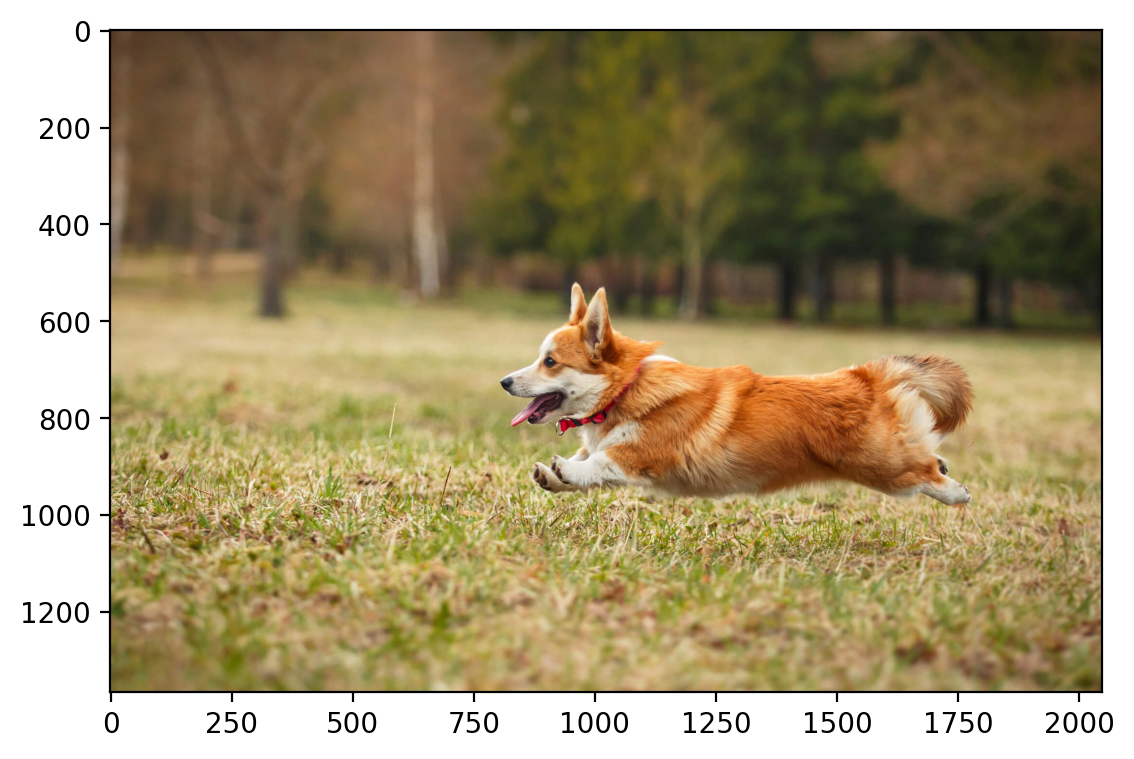

In [5]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [6]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled

MinMaxScaler()

In [8]:
img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([3, 1365, 2048])

In [9]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

#### ***Input image***

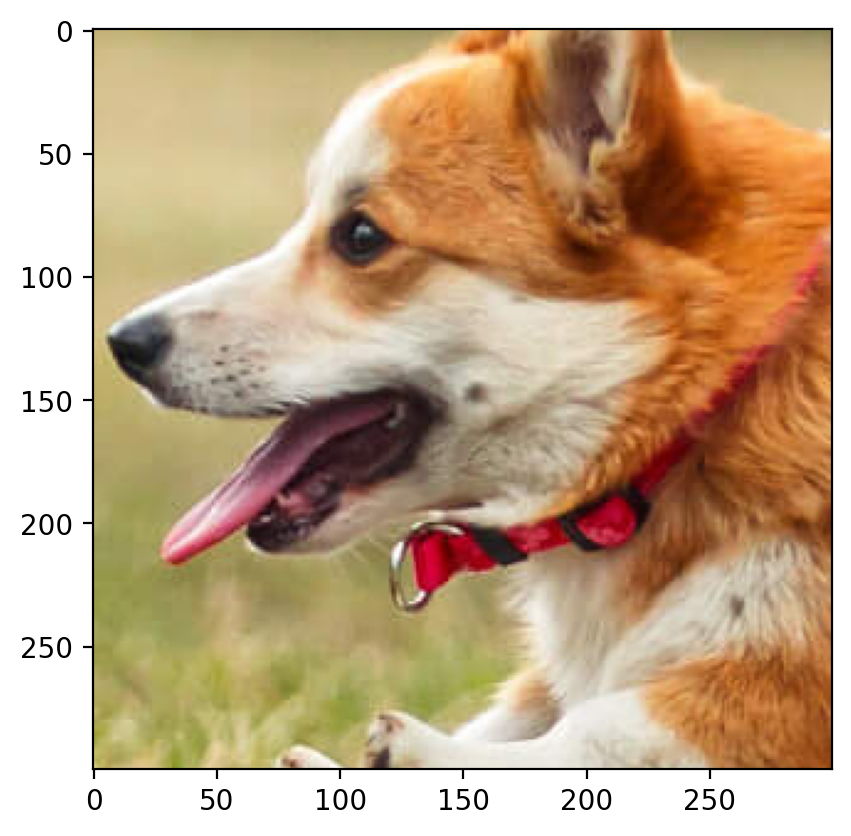

In [10]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

#### *Function to create coordinate map of the image*

In [11]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()

    # Move X to GPU if available
    Y = Y.to(device)

    return X, Y

#### *Function to create Random Furior Features (RFF) of the image*

In [12]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

#### *Function to crop the image*

In [13]:
def crop_img(img,top_left,hight,width):
    x,y = top_left
    crop = torchvision.transforms.functional.crop(img,y,x,hight,width)
    return crop

#### *Function to create missing patch in the image*

In [14]:
def create_img_missing_patches(img,top_left,hight,width):
    """
    Create a missing patch in the image

    Inputs:
        img : torch.Tensor of shape (num_channels, height, width) where you want to create a missing patch
        top_left : tuple of (x,y) coordinates of the top left corner from where the patch should be removed
        hight : hight of the patch that should be removed
        width : width of the patch that should be removed

    Returns:
        missing_patch_img : torch.Tensor of shape (num_channels, height, width) --> full image with the missing patch
        crop : torch.Tensor of shape (num_channels, hight, width) --> missing patch
    """
    y,x = top_left
    crop = crop_img(img,top_left,hight,width)
    crop_copy = crop.clone().float()
    mask = torch.rand(crop.shape) <= 1
    crop_copy[mask] = float('nan')
    missing_patch_img = img.clone().float()
    missing_patch_img[:,x:x+width,y:y+hight] = crop_copy
    return missing_patch_img,crop

#### *Function to randomly remove the subset of the image*

In [15]:
def remove_random_subset(img,portion):
    """
    Remove a random subset of the image

    Inputs:
        img : torch.Tensor of shape (num_channels, height, width) where you want to remove a random subset
        portion : float between 0 and 1 indicating the portion of the image to remove

    Returns:
        crop : torch.Tensor of shape (num_channels, hight, width) --> img with the random subset removed
        bool_mask : torch.Tensor of shape (hight*width,2) --> mask of the removed subset
    """
    crop = img.clone().float()
    mask = torch.rand(crop.shape) <= portion
    crop[mask] = float('nan')
    mask_,_ = create_coordinate_map(mask,1)
    bool_mask = mask_.bool()
    return crop

#### *Function to create a patch and RFF of the image*

In [16]:
def create_patch_features(img,top_left,hight,width,num_features,sigma):
    """
    create a missing patch in the image and create the RFF features

    inputs:
        img : torch.Tensor of shape (num_channels, height, width) where you want to create a missing patch
        top_left : tuple of (x,y) coordinates of the top left corner from where the patch should be removed
        hight : hight of the patch that should be removed
        width : width of the patch that should be removed
        num_features : number of features to be created
        sigma : sigma for the RFF

    Returns:
        missing_patch_img : torch.Tensor of shape (num_channels, height, width) --> full image with the missing patch
        dog_X_scaled : torch.Tensor of shape (height * width, 2) --> coordinate map
        dog_Y : torch.Tensor of shape (height * width, num_channels) --> image map
        X_rff : torch.Tensor of shape (height * width, num_features) --> RFF features

    """

    missing_patch_img,crop = create_img_missing_patches(img,top_left,hight,width)

    dog_X,dog_Y = create_coordinate_map(img,scale=1)
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
    dog_X_scaled = scaler_X.transform(dog_X.cpu())
    dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
    dog_X_scaled = dog_X_scaled.float()

    X_rff = create_rff_features(dog_X_scaled, num_features, sigma)
    return missing_patch_img,dog_X_scaled,dog_Y,X_rff




#### *Function to create a training dataset for the image*

In [17]:
def create_training_data(X_rff,Y,top_left,hight,len_img):
    """
    create the training data for the missing patch
    inputs:
        X_rff : torch.Tensor of shape (height * width, num_features) --> contains the RFF features for whole image
        Y : torch.Tensor of shape (height * width, num_channels) --> contains the image map for whole image
        top_left : tuple of (x,y) coordinates of the top left corner from where the patch should be removed
        hight : hight of the patch that should be removed
        len_img : width of the entire image

    Returns:
        X_train : torch.Tensor of shape (height * width, num_features) --> contains the RFF features excluding the missing patch
        Y_train : torch.Tensor of shape (height * width, num_channels) --> contains the image map excluding the missing patch
    """
    x,y = top_left
    mask = np.array([True for _ in range(len(X_rff))])
    for i in range(hight):
       mask[x*len_img +y +i:x*len_img +y +i + hight] = False
    X_train = X_rff[::1][mask]
    Y_train = Y[::1][mask]
    return X_train,Y_train

#### *Linear regression model to predict the missing patch*

In [18]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

#### *Function to train the model*

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

#### *Function to plot the reconstructed image*

In [20]:
def plot_reconstructed_and_original_image(original_img, net, X, title="", folder='figures',scale=1):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    if not os.path.exists(folder):
        os.makedirs(folder)
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height*scale, width*scale, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.savefig(os.path.join(folder, f"{title}.png"))  # Corrected folder path here
    plt.show()
    plt.close()
    return outputs

##### *Function to create a mask of the image having random subset missing*

In [21]:
def mask_image(img, width, height):
    img_copy = img.clone().float()
    shape = img.shape

    # Generate random indices for masking
    mask_indices = torch.randperm(shape[1] * shape[2])[:width * height]

    # Convert indices to 2D coordinates
    mask_indices_2d = torch.unravel_index(mask_indices, (shape[1], shape[2]))

    # Create a mask
    mask = torch.zeros((shape[1], shape[2]), dtype=torch.bool)
    mask[mask_indices_2d] = True

    # Apply the mask to the image
    for i in range(shape[0]):
        img_copy[i][mask] = float('nan')

    return img_copy, mask

#### *Function to calculate the RMSE and PSNR of the image*

In [ ]:
# RMSE
def rmse(re_img, original_img):
    mse=np.mean(np.square(re_img-original_img))
    return np.sqrt(mse)

# Peak signal to noise ratio
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = np.max(img1)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

##### *Reconstruction of image having a 30x30 missing patch*

In [21]:
img,dog_X,dog_Y,X_rff = create_patch_features(crop,(0,0),30,30,16000,0.008)
X_train,Y_train = create_training_data(X_rff,dog_Y,(0,0),30,30)
net = LinearModel(X_train.shape[1], Y_train.shape[1]).to(device)
train(net, 0.005, X_train, Y_train, 500)


Epoch 0 loss: 0.370998
Epoch 100 loss: 0.054360
Epoch 200 loss: 0.016950
Epoch 300 loss: 0.011727
Epoch 400 loss: 0.009293


0.007610065396875143

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


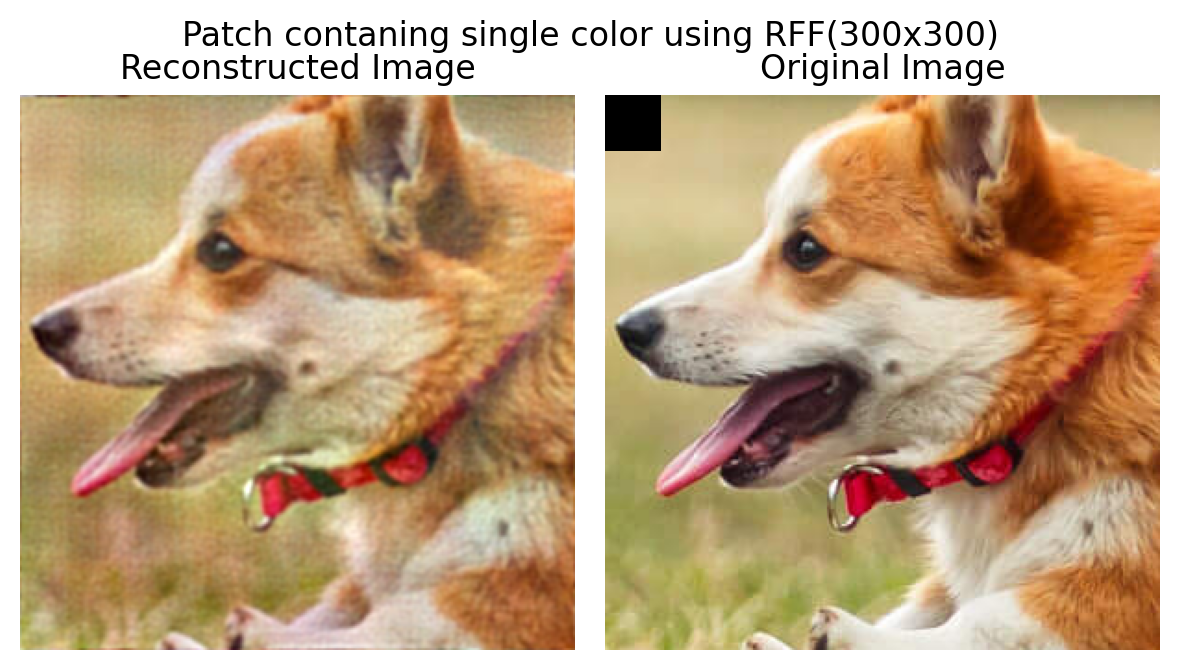

In [22]:
output1 = plot_reconstructed_and_original_image(img, net, X_rff, title="Patch contaning single color using RFF(300x300)", folder='figures',scale=1)

In [29]:
rmse1=rmse(output1.cpu().permute(2,1,0).numpy(), crop.numpy())
psnr1=psnr(output1.cpu().permute(2,1,0).numpy(), crop.numpy())
print("RMSE:-",rmse1)
print("PSNR:-",psnr1)

RMSE 0.25042126846279805
PSNR 13.10431263766585


##### *Reconstruction of image having a randomly missing patch of size 30x30*

Epoch 0 loss: 0.371171
Epoch 100 loss: 0.053687
Epoch 200 loss: 0.017897
Epoch 300 loss: 0.012767
Epoch 400 loss: 0.010102


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


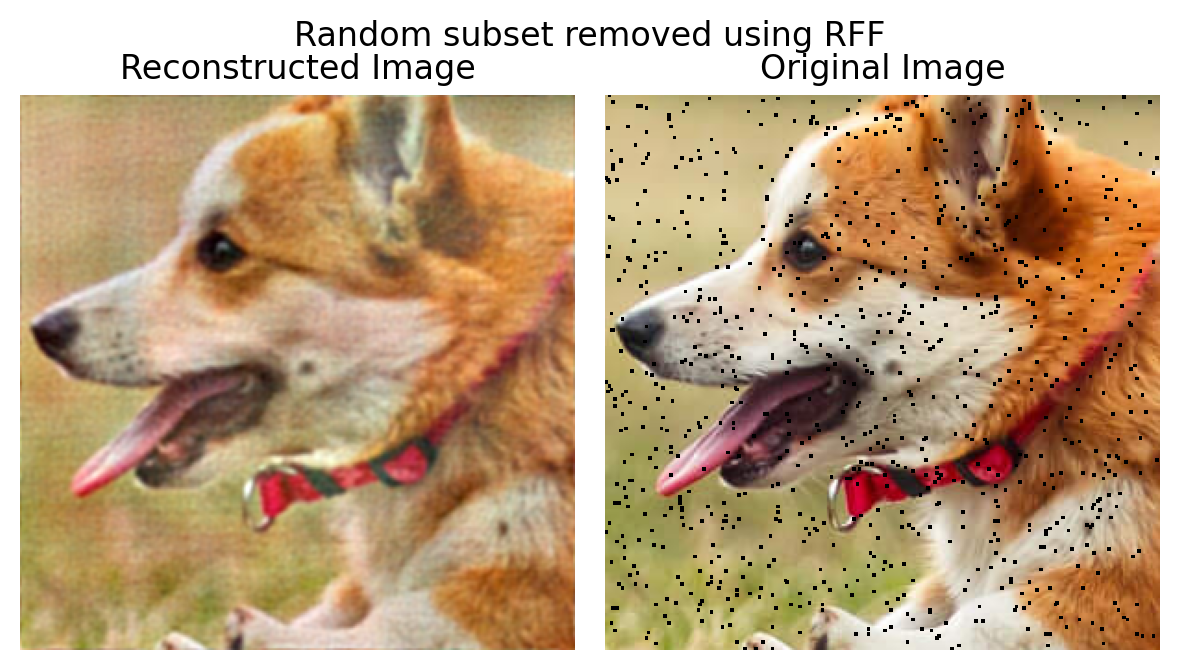

In [22]:
img,mask = mask_image(crop, 30, 30)
mask = mask.view(-1)
mask = ~mask
dog_X,dog_Y = create_coordinate_map(crop,scale=1)
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
X_rff = create_rff_features(dog_X_scaled, 15000, 0.008)
X_train = X_rff[::1][mask]
Y_train = dog_Y[::1][mask]
net = LinearModel(X_train.shape[1], Y_train.shape[1]).to(device)
train(net, 0.005, X_train, Y_train, 500)
output2 = plot_reconstructed_and_original_image(img, net, X_rff, title="Random subset removed using RFF", folder='figures',scale=1)

In [25]:
rmse2=rmse(output2.cpu().permute(2,1,0).numpy(), crop.numpy())
psnr2=psnr(output2.cpu().permute(2,1,0).numpy(), crop.numpy())
print("RMSE:-",rmse2)
print("PSNR:-",psnr2)

RMSE 0.254174338977257
PSNR 12.575900420095252
